<a href="https://colab.research.google.com/github/chhavic4004/-gdi2019-/blob/main/xg_boost_along_with_shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

XGBoost Regression Results:
RMSE: 0.0270
R^2 Score: 0.7751


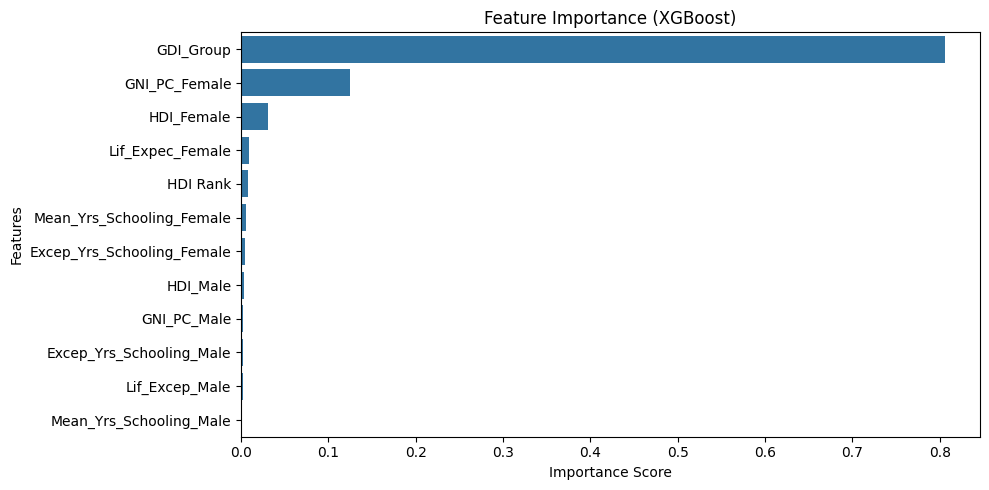

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

# If you don't have xgboost installed, uncomment the next line:
# !pip install xgboost

from xgboost import XGBRegressor

# 1. Load the cleaned GDI data
df = pd.read_csv('GDI_cleaned.csv')

# 2. Encode categorical columns (if any)
categorical_cols = df.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# 3. Select features and target
target_col = 'GDI_Value'
feature_cols = [col for col in df.columns if col != target_col and col != 'Country']

X = df[feature_cols]
y = df[target_col]

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train the XGBoost Regressor
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

# 6. Predict
y_pred_xgb = xgb.predict(X_test)

# 7. Evaluation
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)

print("XGBoost Regression Results:")
print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

# 8. Feature Importance Visualization
import matplotlib.pyplot as plt
import seaborn as sns

importances = xgb.feature_importances_
feat_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=feat_importance, y=feat_importance.index)
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [2]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

grid = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Best cross-validated R^2:", grid.best_score_)


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best cross-validated R^2: 0.8486630063002453


In [3]:
from sklearn.model_selection import cross_val_score

xgb = XGBRegressor(**grid.best_params_, random_state=42)
cv_scores = cross_val_score(xgb, X, y, cv=5, scoring='r2')
print("Cross-validated R^2 scores:", cv_scores)
print("Mean CV R^2:", np.mean(cv_scores))


Cross-validated R^2 scores: [0.37235447 0.7849613  0.90551317 0.79390998 0.45223687]
Mean CV R^2: 0.6617951593891453


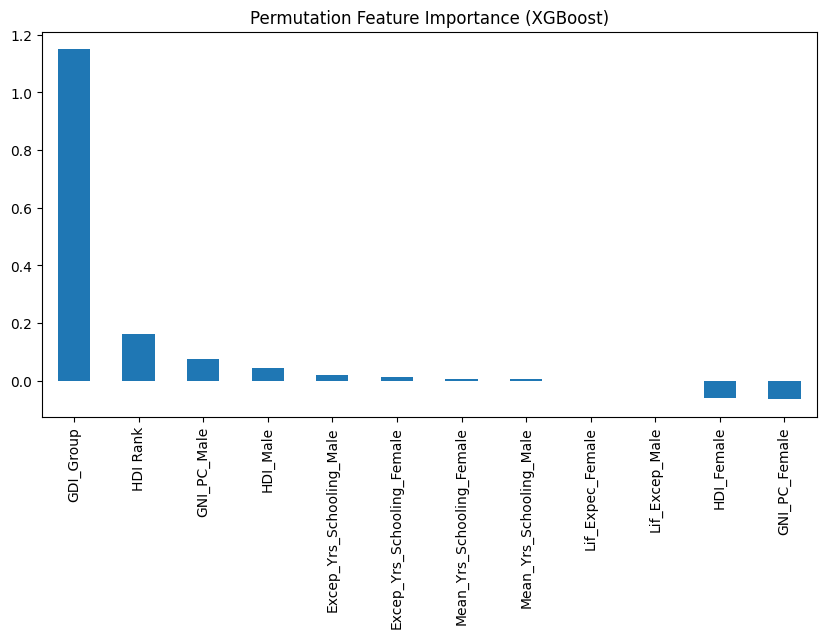

In [4]:
from sklearn.inspection import permutation_importance

xgb.fit(X_train, y_train)
result = permutation_importance(xgb, X_test, y_test, n_repeats=10, random_state=42)
importances = pd.Series(result.importances_mean, index=X.columns)
importances.sort_values(ascending=False).plot.bar(figsize=(10,5), title='Permutation Feature Importance (XGBoost)')
plt.show()


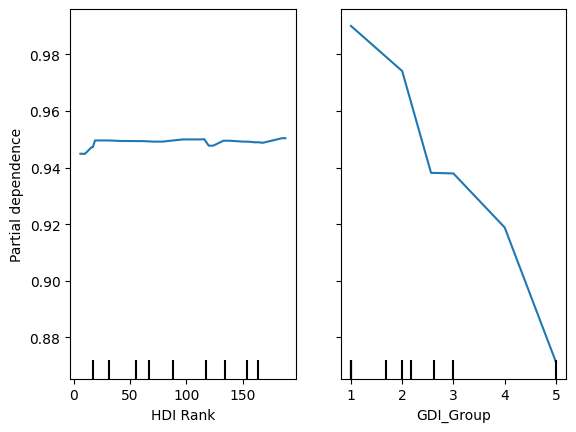

In [5]:
from sklearn.inspection import PartialDependenceDisplay

features_to_plot = [0, 1]  # Replace with indices or names of your most important features
PartialDependenceDisplay.from_estimator(xgb, X_test, features_to_plot)
plt.show()


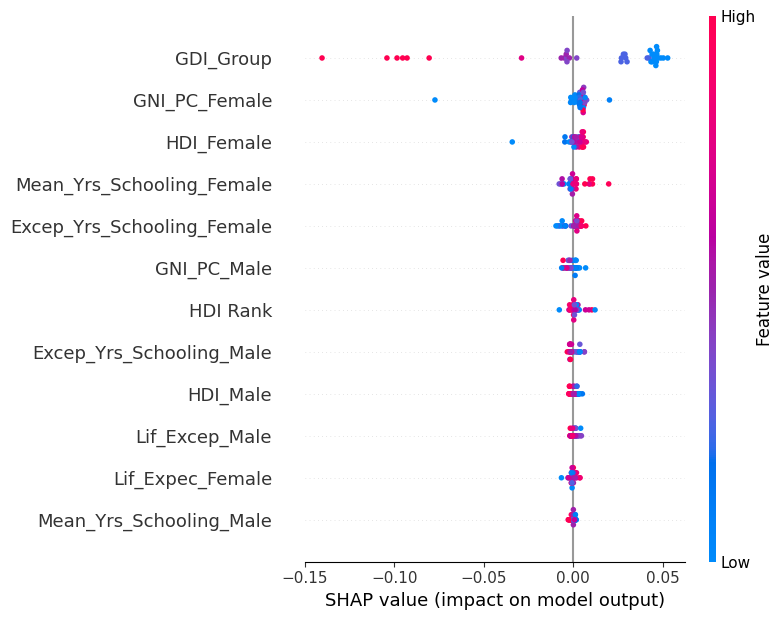

ValueError: visualize() can only display Explanation objects (or arrays of them)!

In [6]:
# If not installed: !pip install shap
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# Force plot for a single prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])


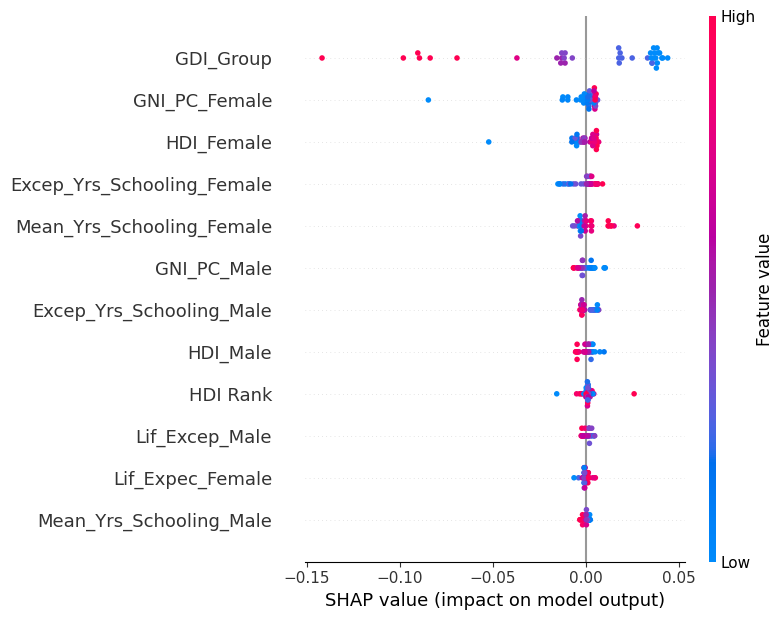

In [7]:
import shap

# After fitting your model and getting shap_values
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_test)

# Summary plot (works as before)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# Force plot for a single prediction
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values.values[0],
    X_test.iloc[0]
)
